In [1]:
#General imports
import math
import numpy as np
import pandas as pd
import seaborn as sns

#Matplotlib specific imports
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm

#Scipy specific imports
from scipy.integrate import odeint

In [2]:
def rxn(C,t):
        #Loading the global variable reaction rates
        global k
        kf1 = kf4 = k[0]                                             
        kr1 = kr4 = k[1]                                             
        kf2 = kf3 = k[2]                                             
        kr2 = kr3 = k[3]                                             
        
        #Loading the initial concentrations
        C_snap = C[0]                   #initial concentration of free T Cell receptor
        C_anti = C[1]                   #initial concentration of free antibody
        C_tumo = C[2]                   #initial concentration of free Tumor cell receptor
        C_snap_anti = C[3]              #initial concentration of bound T Cell - Antibody
        C_anti_tumo = C[4]              #initial concentration of bound Tumor Cell - Antibody
        C_snap_anti_tumo = C[5]         #initial concentration of Ternary Body
        
        #Separation of key equation terms for simplicity
        term1 = kf1 * C_snap * C_anti           #binding of Tcell to antibody
        term2 = kr1 * C_snap_anti               #dissociation of Tcell - antibody
        term3 = kf2 * C_anti * C_tumo           #binding of TumorCell to antibody
        term4 = kr2 * C_anti_tumo               #dissociation of TumorCell - antibody
        term5 = kf3 * C_snap_anti * C_tumo      #binding of Tcell-antibody to Tumor Cell
        term6 = kr3 * C_snap_anti_tumo          #dissociation of Ternary Body
        term7 = kf4 * C_anti_tumo * C_snap      #binding of TumorCell-antibody to T Cell
        term8 = kr4 * C_snap_anti_tumo          #dissociation of Ternary Body

        #ODEs that model the dynamic change in concentration of each chemical species
        d_C_snap_dt = - term1 + term2 - term7 + term8                         #change in free T Cell receptor
        d_C_anti_dt = - term1 + term2 - term3 + term4                         #change in free antibody
        d_C_tumo_dt = - term3 + term4 - term5 + term6                         #change in free Tumor cell receptor
        d_C_snap_anti_dt = + term1 - term2 - term5 + term6                    #change in bound T Cell - Antibody
        d_C_anti_tumo_dt = + term3 - term4 - term7 + term8                    #change in bound Tumor Cell - Antibody
        d_C_snap_anti_tumo_dt = + term5 - term6 + term7 - term8               #change in Ternary Body
        
        return([d_C_snap_dt,d_C_anti_dt,d_C_tumo_dt,d_C_snap_anti_dt,d_C_anti_tumo_dt,d_C_snap_anti_tumo_dt])

In [98]:
#User defined values to determine which simulation to run and compare against experimental values
type_of_tcell = "SN"            #Options = "SN" for synNotch, or "CAR" for SNAP-CAR
type_of_antibody = "Herceptin"      #Options = "FMC63", "Rituximab", "Cetuximab", or "Herceptin"

#Reading in the Experimental Data from the "Data" Folder
experiment = type_of_tcell + "_" + type_of_antibody
df_fit = pd.read_excel('Data/ExperimentalData.xlsx', sheet_name=experiment)

#Reading in the Literature Values from the "Data" Folder
TCell = pd.read_excel('Data/ImportantVariables.xlsx', sheet_name='TCell',index_col='TCR')
Receptors = pd.read_excel('Data/ImportantVariables.xlsx', sheet_name='Receptors',index_col='Target')
Antibodies = pd.read_excel('Data/ImportantVariables.xlsx', sheet_name='Antibodies',index_col='Antibody')

In [99]:
# Simulate the model over a range
N = 30
log_lower_bound =-8
log_upper_bound = 2
antibody_range_array = np.logspace(-4,2,N) #antibody in nM for simulation
parameter_range_array = np.logspace(log_lower_bound,log_upper_bound,N)

time = np.linspace(0,86400,86400)

X, Y = np.meshgrid(antibody_range_array, parameter_range_array)
Z = np.zeros(X.shape)

row = 0
col = 0


for parameter in parameter_range_array:
    #Variables given for the experimental setup
    Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
    reaction_volume = 150                                     #150 uL reaction volume
    number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
    number_of_tumor_cells = 400000                          #400,000 Tumor Cells in reaction 

    #Regular Parameters from before
    receptor = Antibodies['Target'][type_of_antibody]
    number_of_receptors_per_Tcell = 100000                          #(units = molecules per cell) Receptors per T cell
    number_of_receptors_per_tumor = int(Receptors['ave'][receptor]) #(units = molecules per cell) Receptors per Tumor cell

    Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                                   (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Antibody = 1 #1 nM, ususal value is a range

    Initial = [Concentration_of_T_Cells,0,Concentration_of_Tumor_Cells,0,0,0] #THIS IS A NEW ADDITION - NOT PREVIOUSLY DEFINED?

    
    k_binding_snap_to_antibody = parameter #TCell.iloc[0][1] * 
    k_release_snap_to_antibody = 0 #TCell.iloc[0][3]
    k_binding_antibody_to_tumor = Antibodies['k_on'][type_of_antibody] #* param
    k_release_antibody_to_tumor = Antibodies['k_off'][type_of_antibody] #*40 

    k = [k_binding_snap_to_antibody,\
         k_release_snap_to_antibody,\
         k_binding_antibody_to_tumor,\
         k_release_antibody_to_tumor] 
    
    #the for loop to go over the range of the antibody concentrations
    for anti in antibody_range_array:
        Initial[1] = anti
        C = odeint(rxn,Initial,time)
        Z[row,col] = (float((C[-1,5])))
        col += 1
    col = 0
    row += 1
    
#Collapse our Logspace to Linspace because matplotlib has difficulty with logspace plotting
lin_antibody = np.linspace(-4,2,N)
lin_antibody = lin_antibody * 1e-9 * Antibodies.loc[type_of_antibody]['MW'] * 1000 * 1e6 * 1e-3 #conversion nM to ug/mL 

lin_parameter = np.linspace(log_lower_bound,log_upper_bound,N)
lin_X, lin_Y = np.meshgrid(lin_antibody, lin_parameter)
z = Z / Z.max()

In [100]:
np.log10(antibody_range_array.min())

-4.0

In [101]:
antibody_range_array.max()

100.0

In [102]:
x = ['{:.1E}'.format(item) for item in antibody_range_array]
y = ['{:.1E}'.format(item) for item in parameter_range_array]

df2 = pd.DataFrame(data=z.T, columns = y)
df2['xVal'] = x
df2.set_index(['xVal'],inplace=True)
df3 = df2.iloc[::-1]
Z1 = df3.values

x_vals = np.logspace(np.log10(parameter_range_array.min()), np.log10(parameter_range_array.max()), 30)
y_vals = np.logspace(np.log10(antibody_range_array.min()), np.log10(antibody_range_array.max()), 30)

tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tx = [u"${}$".format(tick.format_data(x)) for x in x_vals]
ty = [u"${}$".format(tick.format_data(x)) for x in y_vals]

In [103]:
# tx2 = ['$10^{−8}$','','',\
#       '$10^{−7}$','','',\
#       '$10^{−6}$','','',\
#       '$10^{−5}$','','',\
#       '$10^{−4}$','','',\
#       '$10^{−3}$','','',\
#       '$10^{−2}$','','',\
#       '$10^{−1}$','','',\
#       '$10^{0}$','','',\
#       '$10^{1}$','','']

tx = ['$10^{−8}$','','',\
      '','','',\
      '$10^{−6}$','','',\
      '','','',\
      '$10^{−4}$','','',\
      '','','',\
      '$10^{−2}$','','',\
      '','','',\
      '$10^{0}$','','',\
      '','','$10^{2}$']

ty = ['','$10^{2}$','','','','',\
      '$10^{1}$','','','','',\
      '$10^{0}$','','','','',\
      '$10^{−1}$','','','','',\
      '$10^{-2}$','','','','',\
      '$10^{-3}$','','','']

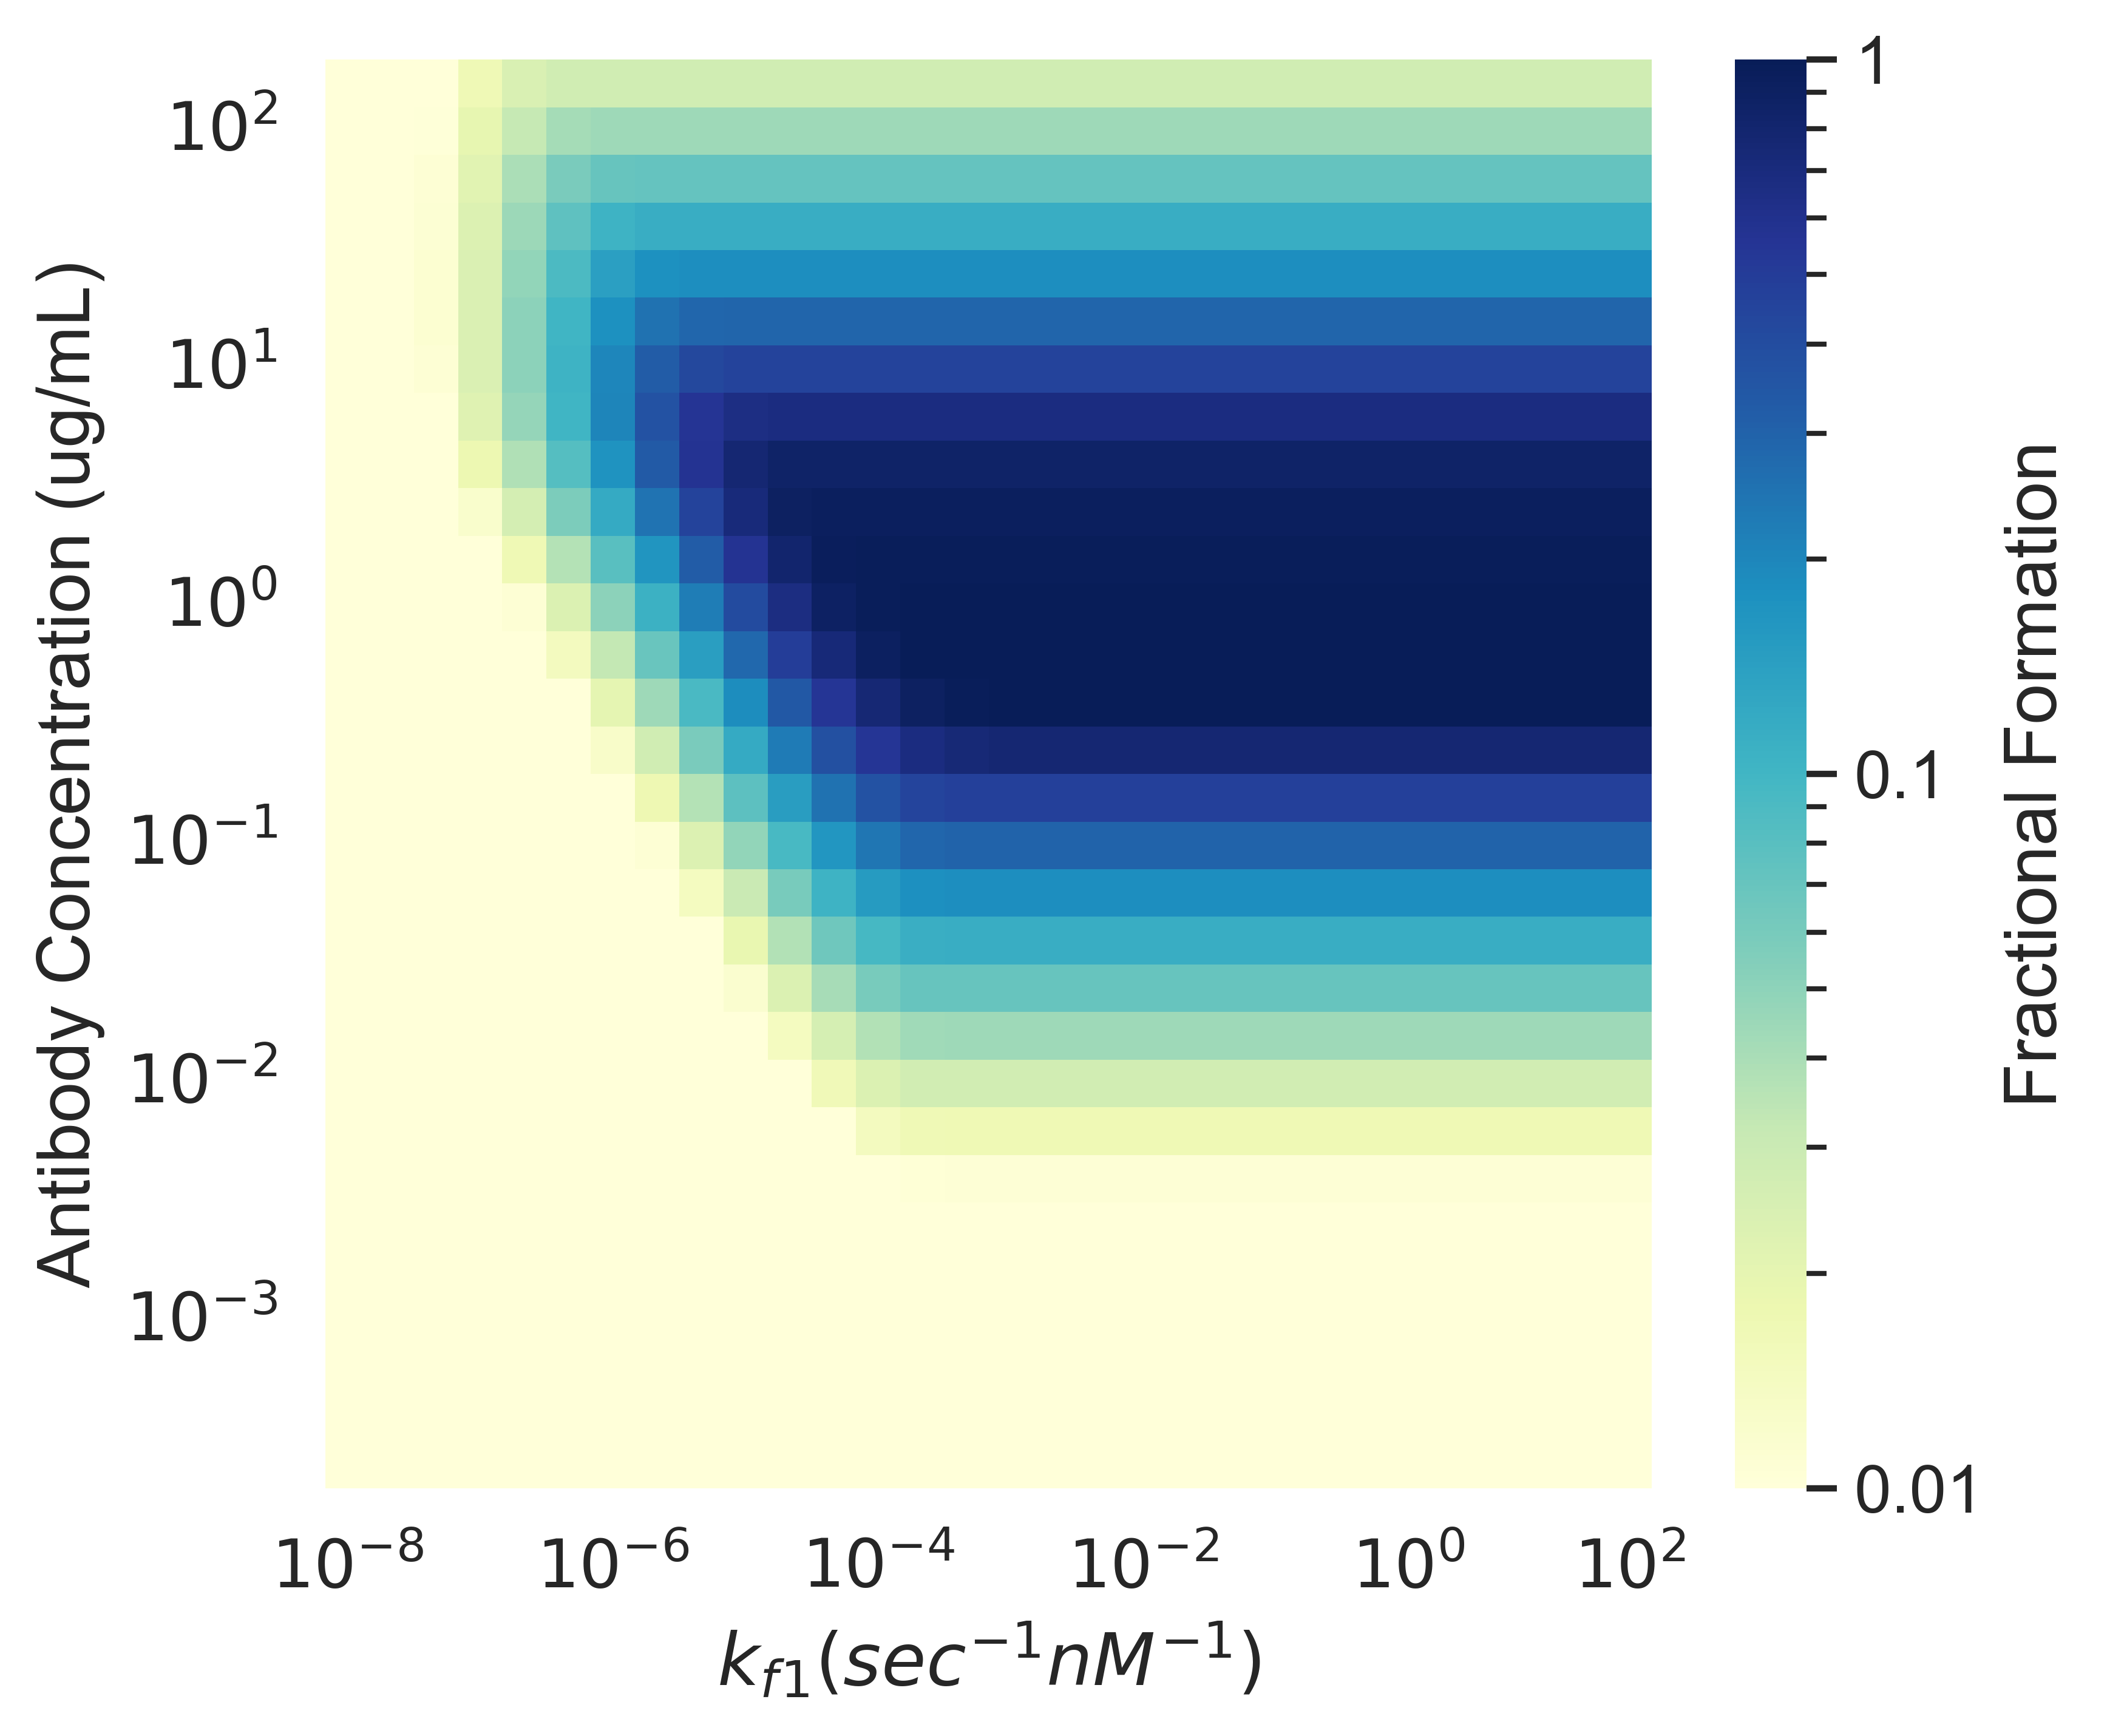

In [104]:
fig = plt.figure(figsize=(6, 5), dpi=600)

cbar_ticks = [math.pow(10, i) for i in range(-2,1)]

# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu', fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)

ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu', fmt='.2g',norm=LogNorm(vmin=0.01, vmax=Z1.max()),\
                 cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)

cbar = ax.collections[0].colorbar
cbar.set_ticks([0.01, .1, 1])
cbar.set_ticklabels(['0.01', '0.1','1'])
# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks},vmin = 0.01, vmax=1)

ax.tick_params(left=False, bottom=False)
ax.tick_params(axis = 'x', labelrotation = 0)
ax.tick_params(axis = 'y', labelrotation = 0)

sns.set(font_scale=1.2)
ax.set(xlabel='$k{_f}{_1} (sec^{-1}nM^{-1})$', ylabel='Antibody Concentration (ug/mL)')
# full_namer = 'Figures/ParameterScan_kf1.png'
plt.tight_layout()
plt.savefig('Figures/C_ParameterScans_pngs/' + 'ParameterScan_kf1' + '.png')
plt.savefig('Figures/D_ParameterScans_svgs/' + 'ParameterScan_kf1' + '.svg', format='svg')
plt.show()

In [105]:
# Simulate the model over a range
N = 30
log_lower_bound = 3
log_upper_bound = 6.2
antibody_range_array = np.logspace(-4,2,N) #antibody in nM for simulation
log_antibody = antibody_range_array * 1e-9 * Antibodies.loc[type_of_antibody]['MW'] * 1000 * 1e6 * 1e-3 #conversion nM to ug/mL 

parameter_range_array = np.logspace(log_lower_bound,log_upper_bound,N)

time = np.linspace(0,86400,86400)

X, Y = np.meshgrid(antibody_range_array, parameter_range_array)
Z = np.zeros(X.shape)

row = 0
col = 0


for parameter in parameter_range_array:
    #Variables given for the experimental setup
    Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
    reaction_volume = 150                                     #150 uL reaction volume
    number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
    number_of_tumor_cells = 400000                          #400,000 Tumor Cells in reaction 

    #Regular Parameters from before
    receptor = Antibodies['Target'][type_of_antibody]
    number_of_receptors_per_Tcell = 100000                          #(units = molecules per cell) Receptors per T cell
    number_of_receptors_per_tumor = parameter #int(Receptors['ave'][receptor]) #(units = molecules per cell) Receptors per Tumor cell

    Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                                   (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Antibody = 1 #1 nM, ususal value is a range

    Initial = [Concentration_of_T_Cells,0,Concentration_of_Tumor_Cells,0,0,0]
    
    k_binding_snap_to_antibody = TCell.iloc[0][1] 
    k_release_snap_to_antibody = 0 #TCell.iloc[0][3]
    k_binding_antibody_to_tumor = Antibodies['k_on'][type_of_antibody] #* param
    k_release_antibody_to_tumor = Antibodies['k_off'][type_of_antibody] #*40 

    k = [k_binding_snap_to_antibody,\
         k_release_snap_to_antibody,\
         k_binding_antibody_to_tumor,\
         k_release_antibody_to_tumor] 
    
    #the for loop to go over the range of the antibody concentrations
    for anti in antibody_range_array:
        Initial[1] = anti
        C = odeint(rxn,Initial,time)
        Z[row,col] = (float((C[-1,5])))
        col += 1
    col = 0
    row += 1
    
#Collapse our Logspace to Linspace because matplotlib has difficulty with logspace plotting
lin_antibody = np.linspace(-4,2,N)
lin_antibody = lin_antibody * 1e-9 * Antibodies.loc[type_of_antibody]['MW'] * 1000 * 1e6 * 1e-3 #conversion nM to ug/mL 

lin_parameter = np.linspace(log_lower_bound,log_upper_bound,N)
lin_X, lin_Y = np.meshgrid(lin_antibody, lin_parameter)
z = Z / Z.max()

In [106]:
y = ['{:.1E}'.format(item) for item in parameter_range_array]
df2 = pd.DataFrame(data=z.T, columns = y)
x = ['{:.1E}'.format(item) for item in log_antibody]
df2['xVal'] = x
df2.set_index(['xVal'],inplace=True)
df3 = df2.iloc[::-1]

In [107]:
x_vals = np.logspace(np.log10(parameter_range_array.min()), np.log10(parameter_range_array.max()), 30)
y_vals = np.logspace(np.log10(antibody_range_array.min()), np.log10(antibody_range_array.max()), 30)

tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tx = [u"${}$".format(tick.format_data(x)) for x in x_vals]
ty = [u"${}$".format(tick.format_data(x)) for x in y_vals]

In [108]:
ty


['$10^{−4}$',
 '$1.610262028 \\times 10^{−4}$',
 '$2.592943797 \\times 10^{−4}$',
 '$4.175318937 \\times 10^{−4}$',
 '$6.723357537 \\times 10^{−4}$',
 '$1.082636734 \\times 10^{−3}$',
 '$1.743328822 \\times 10^{−3}$',
 '$2.807216204 \\times 10^{−3}$',
 '$4.520353656 \\times 10^{−3}$',
 '$7.278953844 \\times 10^{−3}$',
 '$1.172102297 \\times 10^{−2}$',
 '$1.887391822 \\times 10^{−2}$',
 '$3.039195382 \\times 10^{−2}$',
 '$4.893900918 \\times 10^{−2}$',
 '$7.880462816 \\times 10^{−2}$',
 '$1.268961003 \\times 10^{−1}$',
 '$2.043359718 \\times 10^{−1}$',
 '$3.290344562 \\times 10^{−1}$',
 '$5.298316906 \\times 10^{−1}$',
 '$8.531678524 \\times 10^{−1}$',
 '$1.373823796$',
 '$2.212216291$',
 '$3.56224789$',
 '$5.73615251$',
 '$9.236708572$',
 '$1.487352107 \\times 10^{1}$',
 '$2.39502662 \\times 10^{1}$',
 '$3.856620421 \\times 10^{1}$',
 '$6.210169419 \\times 10^{1}$',
 '$10^{2}$']

In [109]:
tx = ['$10^{3}$','','','','','','','','',\
      '$10^{4}$','','','','','','','','',\
      '$10^{5}$','','','','','','','','',\
      '$10^{6}$','','']

ty = ['','$10^{1}$','','','','',\
      '$10^{0}$','','','','',\
      '$10^{−1}$','','','','',\
      '$10^{−2}$','','','','',\
      '$10^{-3}$','','','','',\
      '$10^{-4}$','','','']

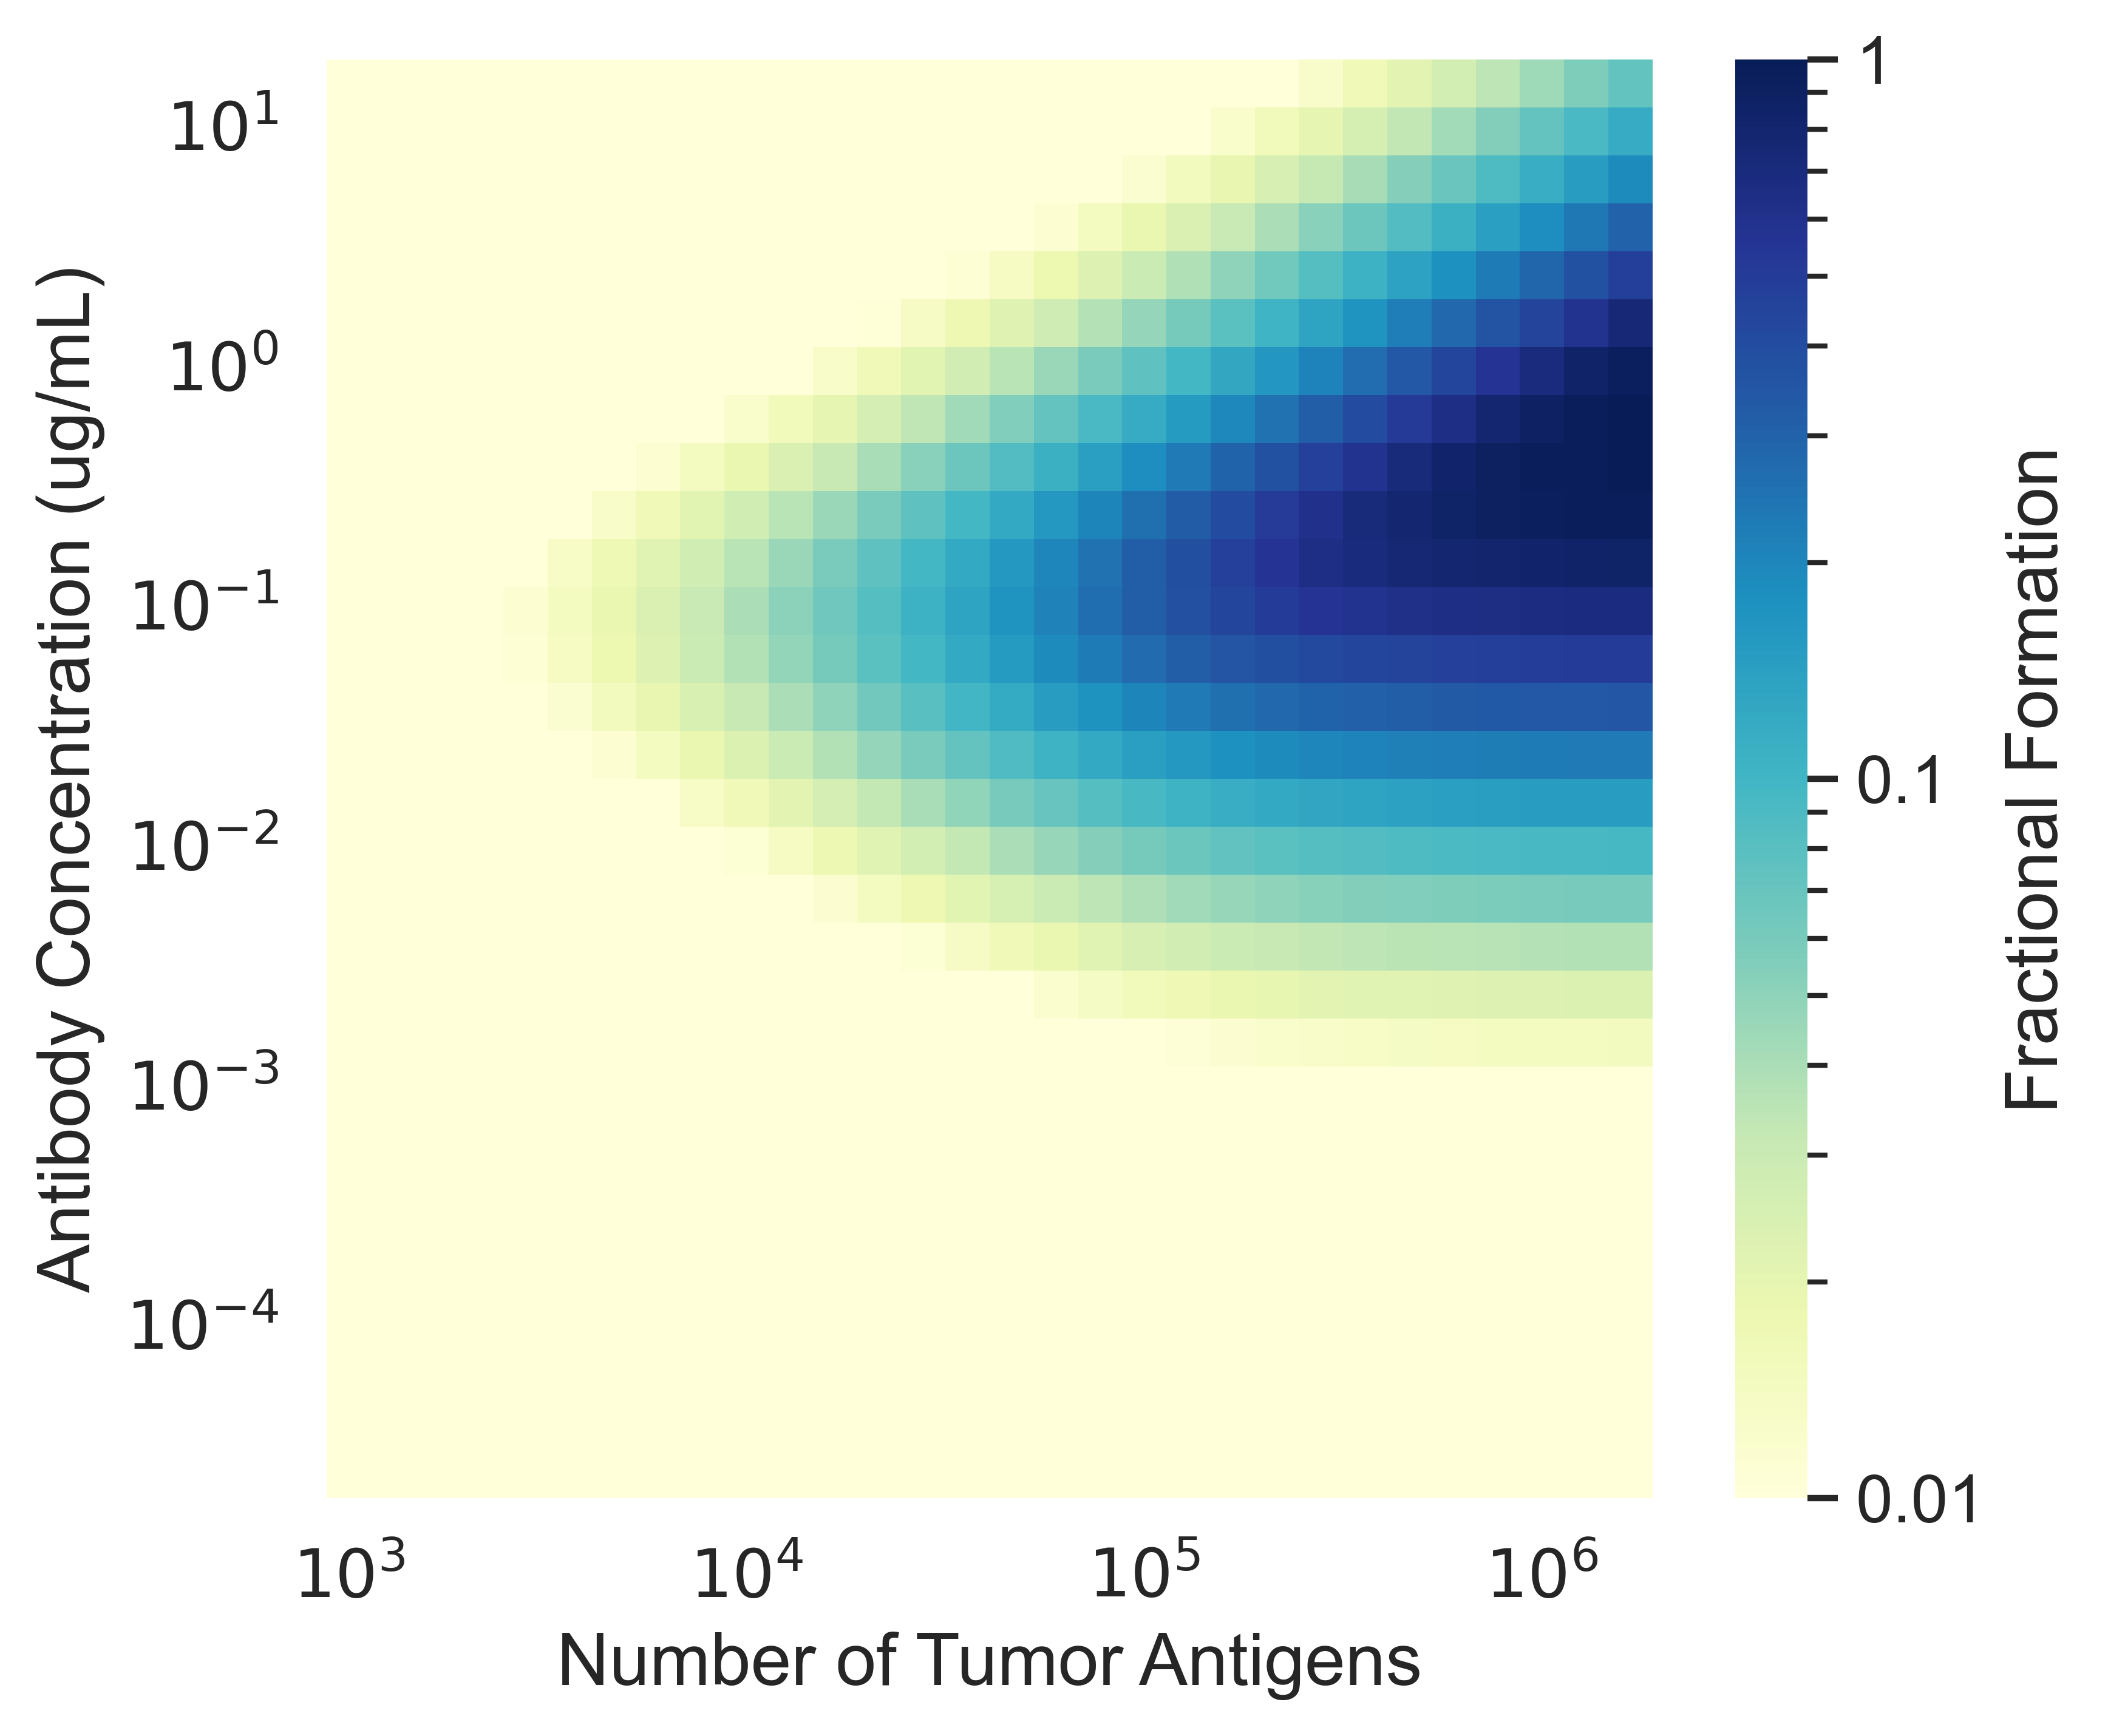

In [110]:
fig = plt.figure(figsize=(6, 5), dpi=600)
cbar_ticks = [math.pow(10, i) for i in range(-2,1)]

Z1 = df3.values
# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks},vmin = 0.01, vmax=1)

# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},\
#                  vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)

ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
                 fmt='.2g',norm=LogNorm(vmin=0.01, vmax=Z1.max()),\
                 cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},\
                 vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)


cbar = ax.collections[0].colorbar
cbar.set_ticks([0.01, .1, 1])
cbar.set_ticklabels(['0.01', '0.1','1'])
# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks},vmin = 0.01, vmax=1)
ax.tick_params(left=False, bottom=False)
ax.tick_params(axis = 'x', labelrotation = 0)
ax.tick_params(axis = 'y', labelrotation = 0)

# ax.set_yscale('log')
# ax.set_xscale('log')
sns.set(font_scale=1.2)
ax.set(xlabel='Number of Tumor Antigens', ylabel='Antibody Concentration (ug/mL)')
plt.tight_layout()
plt.savefig('Figures/C_ParameterScans_pngs/' + 'ParameterScan_TumorAntigen' + '.png')
plt.savefig('Figures/D_ParameterScans_svgs/' + 'ParameterScan_TumorAntigen' + '.svg', format='svg')
plt.show()

In [111]:
# Simulate the model over a range
N = 30
log_lower_bound =-5
log_upper_bound = 1
antibody_range_array = np.logspace(-4,2,N) #antibody in nM for simulation
parameter_range_array = np.logspace(log_lower_bound,log_upper_bound,N)

time = np.linspace(0,86400,86400)

X, Y = np.meshgrid(antibody_range_array, parameter_range_array)
Z = np.zeros(X.shape)

row = 0
col = 0


for parameter in parameter_range_array:
    #Variables given for the experimental setup
    Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
    reaction_volume = 150                                     #150 uL reaction volume
    number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
    number_of_tumor_cells = 400000                          #400,000 Tumor Cells in reaction 

    #Regular Parameters from before
    receptor = Antibodies['Target'][type_of_antibody]
    number_of_receptors_per_Tcell = 100000                          #(units = molecules per cell) Receptors per T cell
    number_of_receptors_per_tumor = int(Receptors['ave'][receptor]) #(units = molecules per cell) Receptors per Tumor cell

    Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                                   (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Antibody = 1 #1 nM, ususal value is a range

    
    k_binding_snap_to_antibody = TCell.iloc[0][1]  
    k_release_snap_to_antibody = TCell.iloc[0][3] * parameter
    k_binding_antibody_to_tumor = Antibodies['k_on'][type_of_antibody] #* param
    k_release_antibody_to_tumor = Antibodies['k_off'][type_of_antibody] #*40 

    k = [k_binding_snap_to_antibody,\
         k_release_snap_to_antibody,\
         k_binding_antibody_to_tumor,\
         k_release_antibody_to_tumor] 
    
    #the for loop to go over the range of the antibody concentrations
    for anti in antibody_range_array:
        Initial[1] = anti
        C = odeint(rxn,Initial,time)
        Z[row,col] = (float((C[-1,5])))
        col += 1
    col = 0
    row += 1
    
#Collapse our Logspace to Linspace because matplotlib has difficulty with logspace plotting
lin_antibody = np.linspace(-4,2,N)
lin_antibody = lin_antibody * 1e-9 * Antibodies.loc[type_of_antibody]['MW'] * 1000 * 1e6 * 1e-3 #conversion nM to ug/mL 

lin_parameter = np.linspace(log_lower_bound,log_upper_bound,N)
lin_X, lin_Y = np.meshgrid(lin_antibody, lin_parameter)
z = Z / Z.max()

In [112]:
y = ['{:.1E}'.format(item) for item in parameter_range_array]
df2 = pd.DataFrame(data=z.T, columns = y)
x = ['{:.1E}'.format(item) for item in antibody_range_array]
df2['xVal'] = x
df2.set_index(['xVal'],inplace=True)
df3 = df2.iloc[::-1]

In [113]:
x_vals = np.logspace(np.log10(parameter_range_array.min()), np.log10(parameter_range_array.max()), 30)
y_vals = np.logspace(np.log10(antibody_range_array.min()), np.log10(antibody_range_array.max()), 30)

tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tx = [u"${}$".format(tick.format_data(x)) for x in x_vals]
ty = [u"${}$".format(tick.format_data(x)) for x in y_vals]

In [114]:
ty

['$10^{−4}$',
 '$1.610262028 \\times 10^{−4}$',
 '$2.592943797 \\times 10^{−4}$',
 '$4.175318937 \\times 10^{−4}$',
 '$6.723357537 \\times 10^{−4}$',
 '$1.082636734 \\times 10^{−3}$',
 '$1.743328822 \\times 10^{−3}$',
 '$2.807216204 \\times 10^{−3}$',
 '$4.520353656 \\times 10^{−3}$',
 '$7.278953844 \\times 10^{−3}$',
 '$1.172102297 \\times 10^{−2}$',
 '$1.887391822 \\times 10^{−2}$',
 '$3.039195382 \\times 10^{−2}$',
 '$4.893900918 \\times 10^{−2}$',
 '$7.880462816 \\times 10^{−2}$',
 '$1.268961003 \\times 10^{−1}$',
 '$2.043359718 \\times 10^{−1}$',
 '$3.290344562 \\times 10^{−1}$',
 '$5.298316906 \\times 10^{−1}$',
 '$8.531678524 \\times 10^{−1}$',
 '$1.373823796$',
 '$2.212216291$',
 '$3.56224789$',
 '$5.73615251$',
 '$9.236708572$',
 '$1.487352107 \\times 10^{1}$',
 '$2.39502662 \\times 10^{1}$',
 '$3.856620421 \\times 10^{1}$',
 '$6.210169419 \\times 10^{1}$',
 '$10^{2}$']

In [115]:
tx = ['$10^{-5}$','','','','','','$10^{-4}$','','',\
      '','','','$10^{-3}$','','','','','',\
      '$10^{-2}$','','','','','','$10^{-1}$','','',\
      '','','$10^{0}$']

ty = ['','$10^{2}$','','','','',\
      '$10^{1}$','','','','',\
      '$10^{0}$','','','','',\
      '$10^{−1}$','','','','',\
      '$10^{-2}$','','','','',\
      '$10^{-3}$','','','']

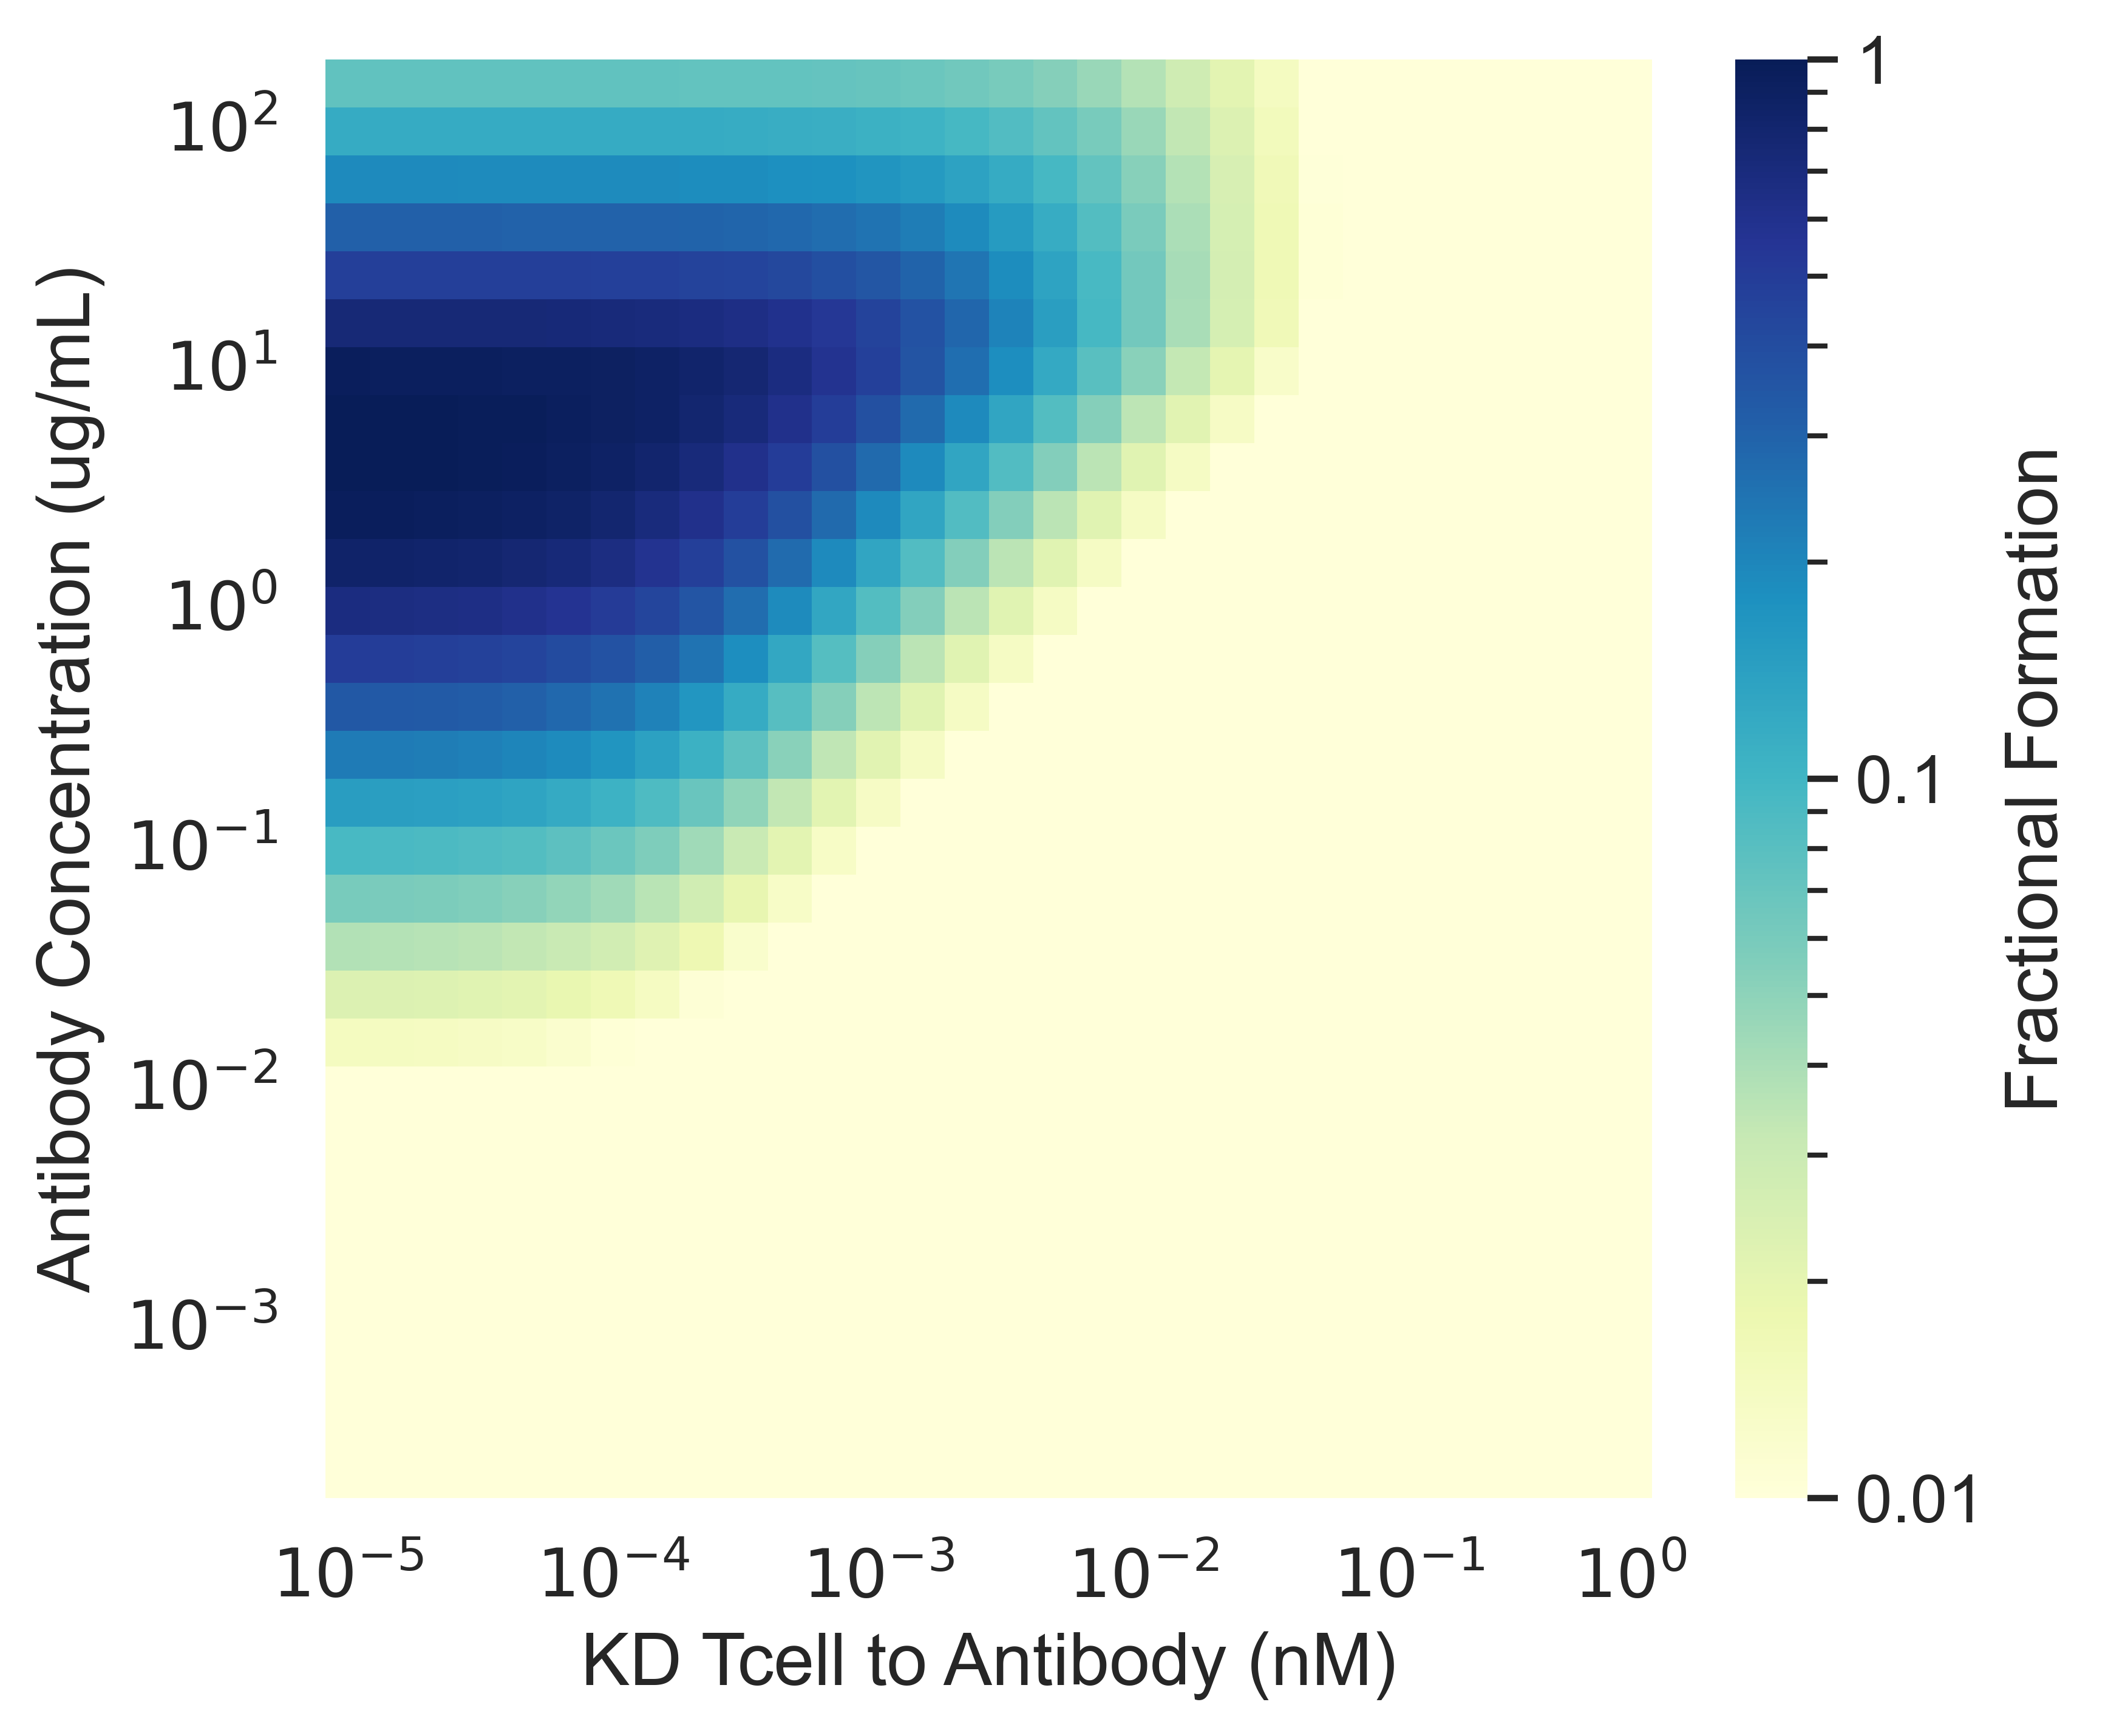

In [116]:
fig = plt.figure(figsize=(6, 5), dpi=600)

cbar_ticks = [math.pow(10, i) for i in range(-2,1)]

Z1 = df3.values
# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks},vmin = 0.01, vmax=1)

# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},\
#                  vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)

ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
                 fmt='.2g',norm=LogNorm(vmin=0.01, vmax=Z1.max()),\
                 cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},\
                 vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)

cbar = ax.collections[0].colorbar
cbar.set_ticks([0.01, .1, 1])
cbar.set_ticklabels(['0.01', '0.1','1'])
# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks},vmin = 0.01, vmax=1)
ax.tick_params(left=False, bottom=False)
ax.tick_params(axis = 'x', labelrotation = 0)
ax.tick_params(axis = 'y', labelrotation = 0)

# ax.set_yscale('log')
# ax.set_xscale('log')
sns.set(font_scale=1.2)
ax.set(xlabel='KD Tcell to Antibody (nM)', ylabel='Antibody Concentration (ug/mL)')
full_namer = 'Figures/ParameterScan_kD.png'
plt.tight_layout()
plt.savefig('Figures/C_ParameterScans_pngs/' + 'ParameterScan_kD' + '.png')
plt.savefig('Figures/D_ParameterScans_svgs/' + 'ParameterScan_kD' + '.svg', format='svg')
plt.show()